In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout

# Dataset
import tensorflow_datasets as tfds

2022-11-01 11:50:08.678949: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-01 11:50:08.678971: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Once GPU has been set up!

# physical_devices = tf.config.list_physical_devices("GPU")
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
(train_ds, test_ds), ds_info = tfds.load(
    'cifar100', 
    split=['train', 'test'], 
    shuffle_files=True, 
    as_supervised=True,  # Return tuple of # (img, label) vs dictionary
    with_info=True
)
print(ds_info)

tfds.core.DatasetInfo(
    name='cifar100',
    full_name='cifar100/3.0.2',
    description="""
    This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path='/home/ryan/tensorflow_datasets/cifar100/3.0.2',
    file_format=tfrecord,
    download_size=160.71 MiB,
    dataset_size=132.03 MiB,
    features=FeaturesDict({
        'coarse_label': ClassLabel(shape=(), dtype=tf.int64, num_classes=20),
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=100),
    }),
    supervised_keys=('image', 'label')

2022-11-01 11:50:11.667776: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-01 11:50:11.667804: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Ryan-Asus): /proc/driver/nvidia/version does not exist
2022-11-01 11:50:11.668588: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(50000,), dtype=int64, numpy=array([66, 23, 40, ..., 82, 34,  8])>

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

In [6]:
df = pd.DataFrame(train_ds, columns=['example', 'label'])
df

,example,label
0,"(((tf.Tensor(151, shape=(), dtype=uint8), tf.T...","tf.Tensor(66, shape=(), dtype=int64)"
1,"(((tf.Tensor(250, shape=(), dtype=uint8), tf.T...","tf.Tensor(23, shape=(), dtype=int64)"
2,"(((tf.Tensor(2, shape=(), dtype=uint8), tf.Ten...","tf.Tensor(40, shape=(), dtype=int64)"
3,"(((tf.Tensor(247, shape=(), dtype=uint8), tf.T...","tf.Tensor(39, shape=(), dtype=int64)"
4,"(((tf.Tensor(160, shape=(), dtype=uint8), tf.T...","tf.Tensor(7, shape=(), dtype=int64)"
...,...,...
49995,"(((tf.Tensor(34, shape=(), dtype=uint8), tf.Te...","tf.Tensor(73, shape=(), dtype=int64)"
49996,"(((tf.Tensor(255, shape=(), dtype=uint8), tf.T...","tf.Tensor(41, shape=(), dtype=int64)"
49997,"(((tf.Tensor(88, shape=(), dtype=uint8), tf.Te...","tf.Tensor(82, shape=(), dtype=int64)"
49998,"(((tf.Tensor(156, shape=(), dtype=uint8), tf.T...","tf.Tensor(34, shape=(), dtype=int64)"


In [12]:
# Image processing files
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image


def add_onehot_encoding(image,label):
    return image,tf.one_hot(label, len(CLASSES))


def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) tuples


In [9]:
# def prepare_dataset(file_name, labeled=True, ordered=False, training=False, augment=None):
def prepare_dataset(dataset, training=False, add_augmentation=False):
    """
    Prepares a train, validation or test either with or without labels (as in the case of the predict set)
    Args:
        training: bool, if true, dataset is repeated and shuffled
        add_augmentationf: function(image, label) -> (image, label) returns an augmented image
    """    
#     labeled = True
#     dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTOTUNE)


    dataset = dataset.map(normalize_resize, num_parallel_calls=AUTOTUNE).cache()

    if add_augmentation:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE) # augments data with supplied function

    if training:
        dataset = dataset.repeat()       # the training dataset must repeat for several epochs
        dataset = dataset.shuffle(1024) # Got value from ds_info.splits["train"].num_examples
    
    return dataset


def configure_for_performance(dataset):
    """
    Batches and prefetches data. See cache, interleave also in https://www.tensorflow.org/guide/data_performance
    """
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)    # prefetch next batch while training (autotune prefetch buffer size)
    return dataset


def normalize_resize(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.divide(image, 255)
    image = tf.image.resize(image, (28, 28))
    return image, label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
    return image, label


def get_labels_from_tfdataset(tfdataset, batched=False):
    labels = list(map(lambda x: x[1], tfdataset)) # Get labels 

    if not batched:
        return tf.concat(labels, axis=0) # concat the list of batched labels

    return labels

In [10]:
# Prepare Training and Test Datasets
train_ds = prepare_dataset(train_ds, training=True, add_augmentation=False)
train_ds = configure_for_performance(train_ds)

test_ds = prepare_dataset(test_ds, training=False, add_augmentation=False)
test_ds = configure_for_performance(test_ds)

print("train_ds", train_ds)
print("test_ds", test_ds)

train_ds <PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
test_ds <PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [ ]:
train_labels = get_labels_from_tfdataset(train_ds)
train_labels

In [ ]:
test_labels = get_labels_from_tfdataset(test_ds)
test_labels

2022-11-01 11:38:56.648431: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


TypeError: Invalid shape (1, 32, 32, 3) for image data

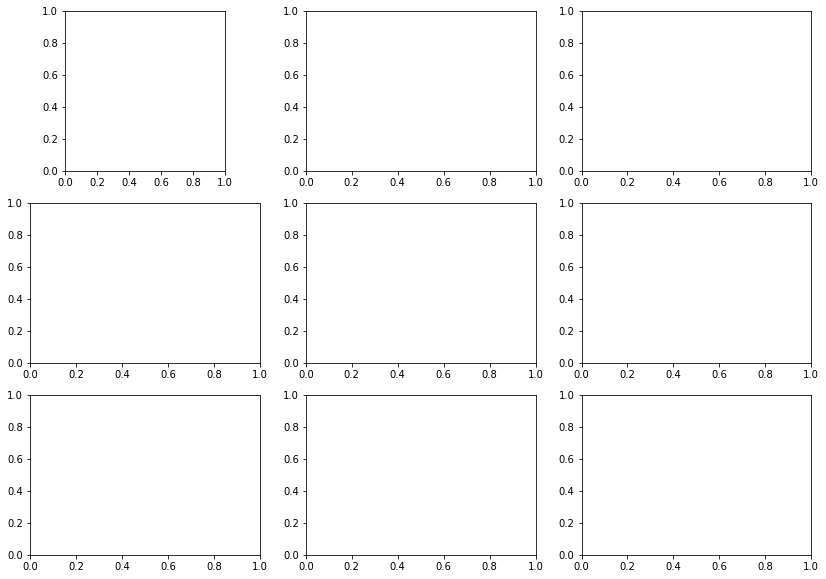

In [19]:
fig, axs = plt.subplots(3, 3, figsize=(14,10))
axs = axs.flatten()

#Plot an example from the training data-set
for (img, label), ax in zip(train_ds.batch(1).take(9),  axs):
    ax.imshow(img)
    ax.set_title(f"{label}")

plt.tight_layout()
plt.show()

In [67]:
train_ds.batch(1).take(1).unbatch()

<_UnbatchDataset element_spec=(TensorSpec(shape=(28, 28, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

TypeError: Invalid shape (64, 28, 28, 3) for image data

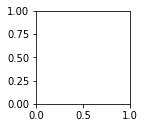

In [65]:
plt.figure(figsize=(12, 12))

for images, labels in train_ds.batch(9).take(1):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(true_fine_labels[labels[i]])
        plt.axis("off")

ValueError: Cannot unbatch an input with scalar components.

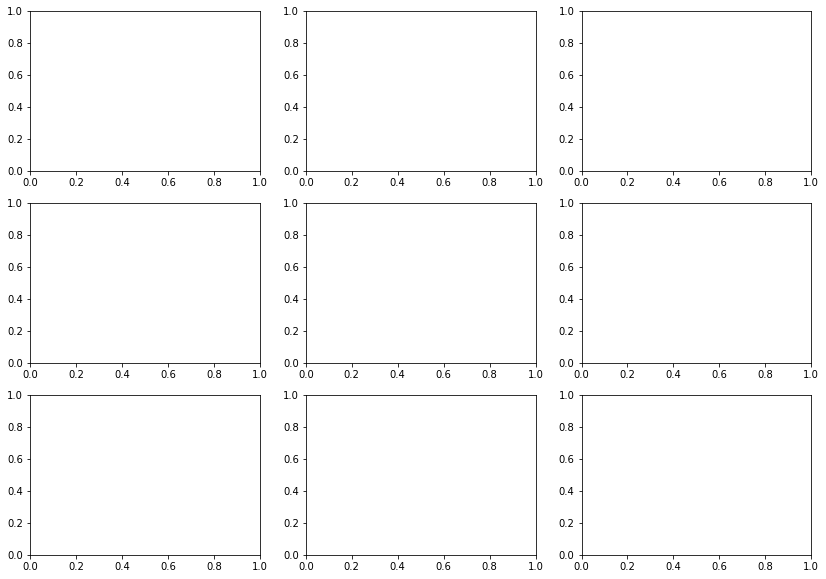

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(14,10))
axs = axs.flatten()

#Plot an example from the training data-set
for (img, class_ind), ax in zip(train_ds.unbatch().take(9),  axs):
    print("class_ind", class_ind)
    ax.imshow(img)
    
    actual_class_ind = true_fine_labels[class_ind]
    ax.set_title(actual_class_ind)

plt.tight_layout()
plt.show()

TypeError: batch() missing 1 required positional argument: 'batch_size'

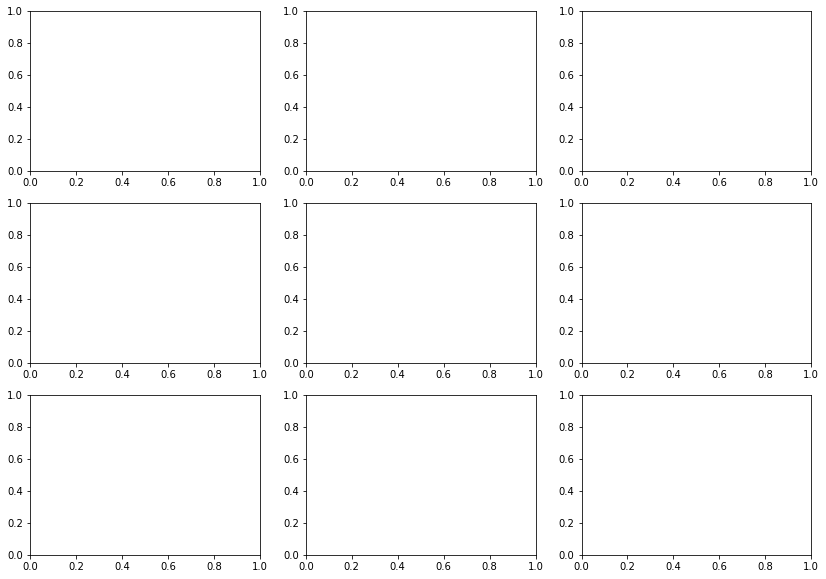

In [14]:
fig, axs = plt.subplots(3, 3, figsize=(14,10))
axs = axs.flatten()

#Plot an example from the training data-set
for (img, class_ind), ax in zip(list(train_ds.batch().unbatch(),  axs)):
    ax.imshow(img)
    ax.set_title(true_fine_labels[class_ind])

plt.tight_layout()
plt.show()

In [19]:
# labels
true_fine_labels = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'] 

# true_course_labels: ['aquatic_mammals', 'fish', 'flowers', 'food_containers', 'fruit_and_vegetables', 'household_electrical_devices', 'household_furniture', 'insects', 'large_carnivores', 'large_man-made_outdoor_things', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 'medium_mammals', 'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals', 'trees', 'vehicles_1', 'vehicles_2']


GCS_DS_PATH = KaggleDatasets().get_gcs_path('cifar100') #define path to google cloud storage bucket
GCS_DS_PATH


NameError: name 'KaggleDatasets' is not defined

In [ ]:
# we use the 512x512x3 data 
IMAGE_SIZE = [512, 512]
GCS_PATH = GCS_DS_PATH + f'/tfrecords-jpeg-{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}'
AUTO = tf.data.experimental.AUTOTUNE

# note we are going to split up the validation folder into validation and test data
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VAL_TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
PRED_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

In [6]:
# Data Dir
data_dir = "./datasets"
os.makedirs(data_dir, exist_ok=True)

# Download dataset
dataset_url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
cifar_folder = tf.keras.utils.get_file("cifar_images", origin=dataset_url, cache_dir='.', extract=True)
print(f"Downloaded to {cifar_folder}")

169001437/169001437 [==============================] - 54s 0us/step
Downloaded to ./datasets/cifar_images


In [5]:
data_dir = pathlib.Path(cifar_folder)
data_dir

PosixPath('datasets/cifar_images')

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


In [8]:

# (train_ds, val_ds, test_ds), metadata = tfds.load(
#     'cifar100',
#     split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
#     with_info=True,
#     as_supervised=True,
# )

# Construct a tf.data.Dataset
ds = tfds.load('cifar100', split='train', shuffle_files=True)

# Build your input pipeline
ds = ds.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)
for example in ds.take(1):
    image, label = example["image"], example["label"]
    print(label)
    # plt.imshow(image)



2022-10-31 18:23:00.197417: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

2022-10-31 18:24:31.824102: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-31 18:24:31.824129: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Ryan-Asus): /proc/driver/nvidia/version does not exist
2022-10-31 18:24:31.825330: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Shuffling /home/ryan/tensorflow_datasets/cifar100/3.0.2.incompleteLDT1HW/cifar100-train.tfrecord*...:   0%|   …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /home/ryan/tensorflow_datasets/cifar100/3.0.2.incompleteLDT1HW/cifar100-test.tfrecord*...:   0%|    …

Dataset cifar100 downloaded and prepared to /home/ryan/tensorflow_datasets/cifar100/3.0.2. Subsequent calls will reuse this data.


2022-10-31 18:24:58.698301: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [11]:
ds

<PrefetchDataset element_spec={'coarse_label': TensorSpec(shape=(None, None, None), dtype=tf.int64, name=None), 'id': TensorSpec(shape=(None, None, None), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, None, 32, 32, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(None, None, None), dtype=tf.int64, name=None)}>

In [10]:
# Build your input pipeline
ds = ds.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)
for example in ds.take(1):
    image, label = example["image"], example["label"]
    print(label)


InvalidArgumentError: Cannot batch tensors with different shapes in component 0. First element had shape [32] and element 19 had shape [16]. [Op:IteratorGetNext]

In [ ]:
# # Credit to https://www.kaggle.com/tusharkendre/tpu-flowers

# def add_random_erasing(img, sl=0.1, sh=0.2, rl=0.4, p=0.3):
#     h = tf.shape(img)[0]
#     w = tf.shape(img)[1]
#     c = tf.shape(img)[2]
#     origin_area = tf.cast(h*w, tf.float32)

#     e_size_l = tf.cast(tf.round(tf.sqrt(origin_area * sl * rl)), tf.int32)
#     e_size_h = tf.cast(tf.round(tf.sqrt(origin_area * sh / rl)), tf.int32)

#     e_height_h = tf.minimum(e_size_h, h)
#     e_width_h = tf.minimum(e_size_h, w)

#     erase_height = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_height_h, dtype=tf.int32)
#     erase_width = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_width_h, dtype=tf.int32)

#     erase_area = tf.zeros(shape=[erase_height, erase_width, c])
#     erase_area = tf.cast(erase_area, tf.uint8)

#     pad_h = h - erase_height
#     pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
#     pad_bottom = pad_h - pad_top

#     pad_w = w - erase_width
#     pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
#     pad_right = pad_w - pad_left

#     erase_mask = tf.pad([erase_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
#     erase_mask = tf.squeeze(erase_mask, axis=0)
#     erased_img = tf.multiply(tf.cast(img,tf.float32), tf.cast(erase_mask, tf.float32))

#     return tf.cond(tf.random.uniform([], 0, 1) > p, lambda: tf.cast(img, img.dtype), lambda:  tf.cast(erased_img, img.dtype))

In [18]:
list(train_ds.as_numpy_iterator())[:1]

[(array([[[151, 154, 145],
          [144, 147, 135],
          [141, 143, 134],
          ...,
          [ 44,  38,  39],
          [112, 100,  96],
          [145, 127, 120]],
  
         [[153, 156, 150],
          [141, 144, 135],
          [139, 142, 136],
          ...,
          [ 68,  59,  59],
          [131, 113, 106],
          [121, 101,  94]],
  
         [[163, 165, 161],
          [150, 153, 145],
          [147, 149, 144],
          ...,
          [ 75,  66,  60],
          [101,  86,  77],
          [ 83,  77,  73]],
  
         ...,
  
         [[150, 150, 162],
          [ 51,  52,  67],
          [ 46,  42,  56],
          ...,
          [ 60,  59,  48],
          [ 71,  73,  56],
          [ 58,  62,  44]],
  
         [[146, 158, 168],
          [ 92, 106, 116],
          [ 73,  77,  85],
          ...,
          [ 54,  55,  40],
          [ 59,  66,  41],
          [ 52,  56,  28]],
  
         [[ 92,  95, 105],
          [ 86,  90, 100],
          [ 77,  74,  82

In [25]:
train_ds.batch()

TypeError: batch() missing 1 required positional argument: 'batch_size'

In [12]:
# Load dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

169001437/169001437 [==============================] - 33s 0us/step


In [14]:
print(f"x_train shape: {x_train.shape}")

x_train shape: (50000, 32, 32, 3)


### Check for Missing Data

In [15]:
train_nan = np.isnan(x_train).sum()
print(f"train data Nans: {train_nan[train_nan != 0]}")

train_nan = np.isnan(y_train).sum()
print(f"train data labels Nans: {train_nan[train_nan != 0]}")

test_nan = np.isnan(x_test).sum()
print(f"test data Nans: {test_nan[test_nan != 0]}")

test_nan = np.isnan(y_test).sum()
print(f"test data labels Nans: {test_nan[test_nan != 0]}")

train data Nans: []
train data labels Nans: []
test data Nans: []
test data labels Nans: []


### Data Visualisation

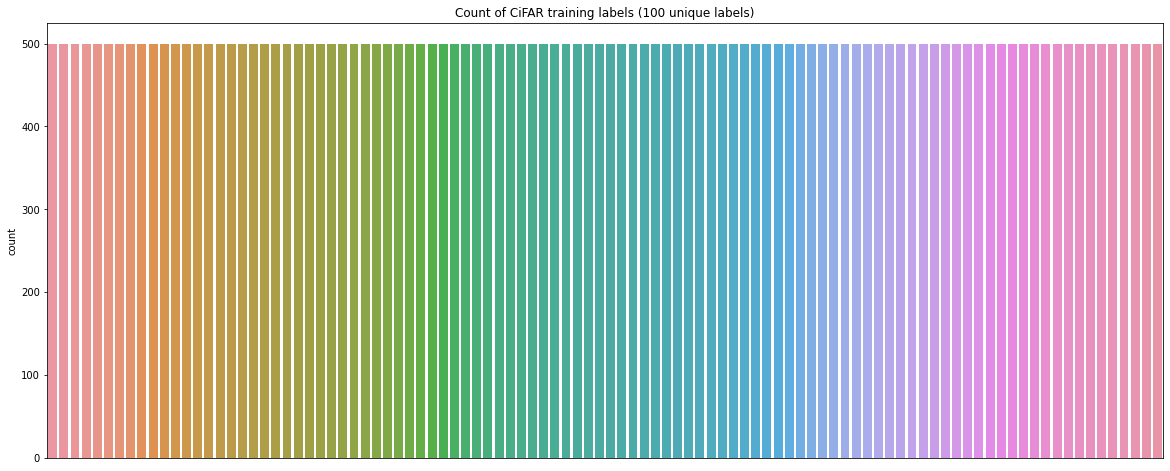

In [30]:
# Distribution of the digits in the dataset

y_train_flat = y_train.flatten()

fig, ax = plt.subplots(figsize=(20,8))
sns.countplot(x=y_train_flat, ax=ax)
ax.set_title(f"Count of CiFAR training labels ({len(np.unique(y_train_flat))} unique labels)")
plt.xticks([])
plt.show()

We have 500 counts of each label

###  Data Pre-processing

- The input data images are 2D grayscale pixel data (they have no color information and are 2D arrays) so we need to add an extra channel dimension to comply with the input format to the CNN. This needs to be in the form [row, columns, channels] where channels represents the color channels of the input data. 
- We scaling the pixel values when training a CNN to help the algorithms quickly reach the minima of the cost function (makes the flow of gradient descent smooth) 

In [33]:
# determine the shape of the input images
input_shape = x_train.shape[1:]

# determine the number of classes
n_classes = len(np.unique(y_train))
print(f"input_shape: {input_shape}")
print(f"n_classes: {n_classes}")


# normalize pixel values and parse as float32 to speed up training
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

input_shape: (32, 32, 3)
n_classes: 100


## Display Handwritten digitis

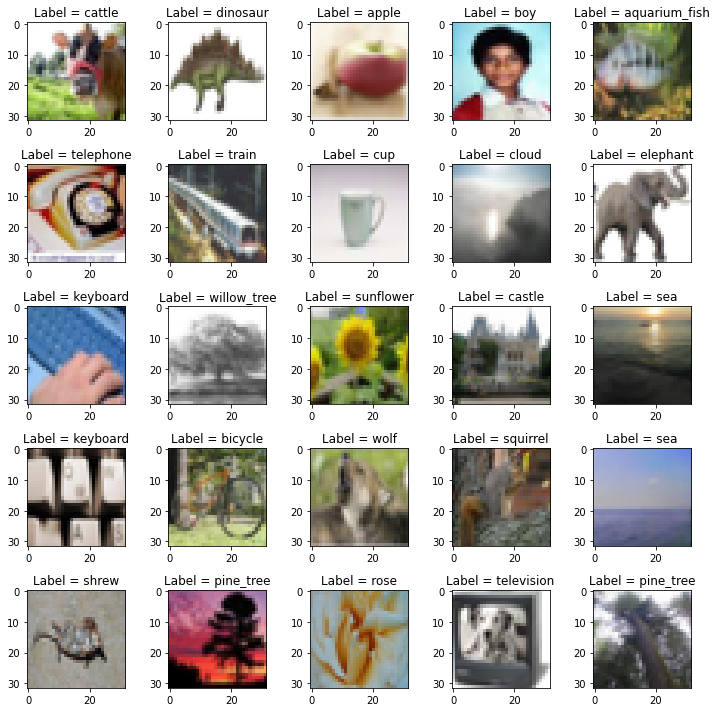

In [41]:
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
axs = axs.flatten()

# plot first few images
for i in range(25):
    ax = axs[i]
    # define subplot
    
    # plot raw pixel data
    ax.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    label_ind = y_train_flat[i]
    ax.set_title(f"Label = {true_fine_labels[label_ind]}")

# show the figure
plt.tight_layout()
plt.show()

## Define the model

What does `kernel_initializer='he_uniform'` do?
Initilized the kernel weights by drawing samples from a uniform distribution within [-limit, limit], where limit = sqrt(6 / fan_in) (fan_in is the number of input units in the weight tensor).

What is a `MaxPool2D` layer?
- Max pooling operation for 2D spatial data (Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size ) for each channel of the input)
- This ensures translation invariance

What is a `Flatten` layer?
Flatten layer is used to make the multidimensional input one-dimensional, commonly used in the transition from the convolution layer to the full connected layer.


What is a `Dense` layer?
A densely-connected NN layer in which every output depends on every input

What is a `Dropout` layer?
The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting

Why do we use `sparse_categorical_crossentropy` loss function and `accuracy` for accuracy?
We use "sparse" since we are not one hot encoding the labels.


What is the difference between batch size and ephocs when building NN's?
- The batch size is a hyperparameter of gradient descent that controls the number of training samples to work through before the model’s internal parameters are updated.
- The number of epochs is a hyperparameter of gradient descent that controls the number of complete passes through the training dataset.


What does Max

In [60]:
input_shape

(32, 32, 3)

In [94]:
from tensorflow.keras.regularizers import l2

In [122]:

model = Sequential()

# Conv2D():
#     - filters,
#     - kernel_size,
#     - strides
    
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPool2D((2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.25))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 2, 2, 128)      

In [123]:
# Define loss and optimizer
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [124]:
history = {}

In [125]:
# fit the model
history['mnist_1'] = model.fit(
    x_train, 
    y_train, 
    validation_split = 0.2,
    epochs=10,
    batch_size=64, 
    verbose=True,
    use_multiprocessing=True
)

print("Done")

Epoch 1/10
625/625 [==============================] - 15s 24ms/step - loss: 4.1175 - accuracy: 0.0727 - val_loss: 3.7633 - val_accuracy: 0.1336
Epoch 2/10
625/625 [==============================] - 14s 23ms/step - loss: 3.5719 - accuracy: 0.1632 - val_loss: 3.4331 - val_accuracy: 0.1937
Epoch 3/10
625/625 [==============================] - 14s 23ms/step - loss: 3.2942 - accuracy: 0.2155 - val_loss: 3.2920 - val_accuracy: 0.2179
Epoch 4/10
625/625 [==============================] - 14s 23ms/step - loss: 3.1087 - accuracy: 0.2526 - val_loss: 3.1277 - val_accuracy: 0.2520
Epoch 5/10
625/625 [==============================] - 15s 24ms/step - loss: 2.9602 - accuracy: 0.2831 - val_loss: 3.0613 - val_accuracy: 0.2718
Epoch 6/10
625/625 [==============================] - 15s 24ms/step - loss: 2.8399 - accuracy: 0.3074 - val_loss: 2.9640 - val_accuracy: 0.2937
Epoch 7/10
625/625 [==============================] - 15s 24ms/step - loss: 2.7378 - accuracy: 0.3297 - val_loss: 2.9111 - val_accuracy:

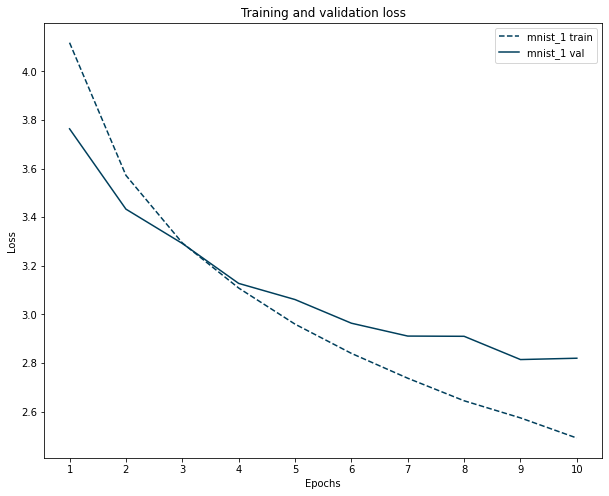

In [126]:
# Plot Train and Validation loss

fig, ax = plt.subplots(1,1, figsize=(10,8))
colours = ["#003f5c","#bc5090", "#228b22"] 

for model_name, color in zip(["mnist_1"], colours):

    history_dict = history[model_name].history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)
    plt.xticks(np.arange(1,21, 1))
    plt.plot(epochs, loss, label=f"{model_name} train", linestyle="--", color=color)
    plt.plot(epochs, val_loss, label=f"{model_name} val", color=color)
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    
plt.legend()
plt.show()

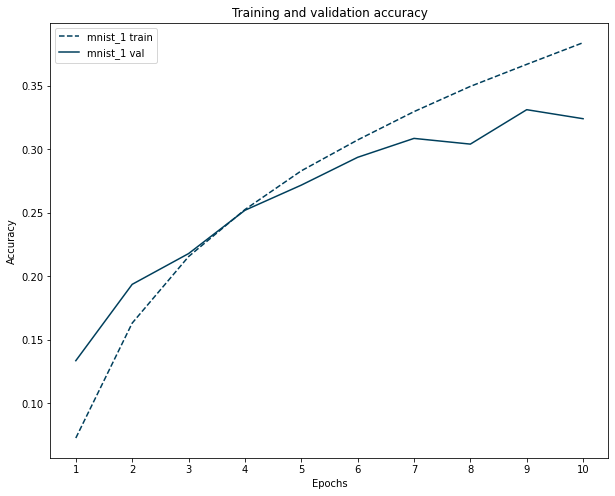

In [127]:
# Plot Train and Validation Accuracy

fig, ax = plt.subplots(1,1, figsize=(10,8))
colours = ["#003f5c","#bc5090", "#228b22"] 

for model_name, color in zip(["mnist_1"], colours):

    history_dict = history[model_name].history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']

    epochs = range(1, len(loss) + 1)
    plt.xticks(np.arange(1,21, 1))
    plt.plot(epochs, acc, label=f"{model_name} train", linestyle="--", color=color)
    plt.plot(epochs, val_acc, label=f"{model_name} val", color=color)
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    

plt.legend()
plt.show()

In [128]:
# Evaluate the model

loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Accuracy: {accuracy:.3f}")
print(f"Loss: {loss:.3f}")

Accuracy: 0.335
Loss: 2.765


In [58]:
# # Evaluate the model

# loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
# print(f"Accuracy: {accuracy:.3f}")
# print(f"Loss: {loss:.3f}")

Accuracy: 0.331
Loss: 2.683


1/1 [==============================] - 0s 44ms/step
actual_label 49
predicted_label 30
1/1 [==============================] - 0s 14ms/step
actual_label 33
predicted_label 80
1/1 [==============================] - 0s 14ms/step
actual_label 72
predicted_label 72
1/1 [==============================] - 0s 14ms/step
actual_label 51
predicted_label 13
1/1 [==============================] - 0s 15ms/step
actual_label 71
predicted_label 71
1/1 [==============================] - 0s 15ms/step
actual_label 92
predicted_label 79
1/1 [==============================] - 0s 17ms/step
actual_label 15
predicted_label 80
1/1 [==============================] - 0s 18ms/step
actual_label 14
predicted_label 7
1/1 [==============================] - 0s 17ms/step
actual_label 23
predicted_label 71
1/1 [==============================] - 0s 16ms/step
actual_label 0
predicted_label 83
1/1 [==============================] - 0s 15ms/step
actual_label 71
predicted_label 87
1/1 [==============================] - 0s 17m

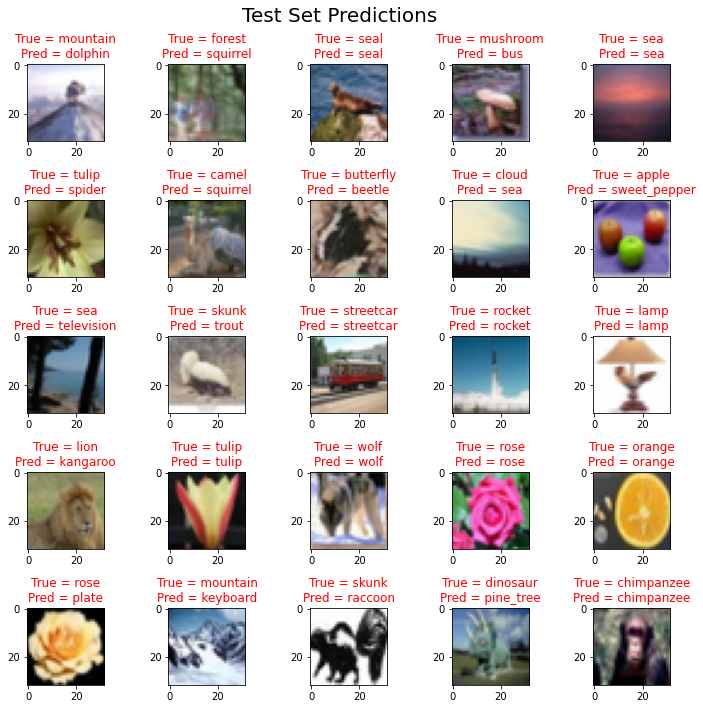

In [59]:
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
axs = axs.flatten()

# plot first few images
for i in range(25):
    ax = axs[i]
    # define subplot
    
    # plot raw pixel data
    image = x_test[i]
    ax.imshow(image, cmap=plt.get_cmap('gray'))
    predicted_label_arr = model.predict(np.asarray([image]))
    predicted_label = np.argmax(predicted_label_arr, -1)[0]
    
    actual_label = y_test[i][0]
    print("actual_label", actual_label)
    print("predicted_label", predicted_label)
    
    
    title = f"True = {true_fine_labels[actual_label]}\nPred = {true_fine_labels[predicted_label]}"
    if actual_label == predicted_label:
        colour = "blue"
    else:
        color = "red"
    
    ax.set_title(title, color=color)

# show the figure
plt.suptitle("Test Set Predictions", fontsize=20)
plt.tight_layout()
plt.show()

## TODO
- Add data Augmentation with TF pipeline and state the benifits
- Add Early stopping call back criteria
- Add tensorboard logs